In [44]:
# Loading all the libraries

import glob
import numpy as np
import pandas as pd
from nilearn import signal, plotting

from scipy import stats

from nltools.data import Adjacency, Brain_Data
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr

from sklearn.metrics import pairwise_distances

%matplotlib inline


In [2]:
# Data directory

# Path to data in my PC
path_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_1_ASD\\*.txt'
path_Non_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_2_Non_ASD\\*.txt'

# List of all the text files
sub_list_1 = [x for x in glob.iglob(path_ASD, recursive=True)]
print('Number of ASD participants:', len(sub_list_1))
sub_list_2 = [x for x in glob.iglob(path_Non_ASD, recursive=True)]
print('Number of Non-ASD participants:', len(sub_list_2))

# Initiating empty list for all time points
time_p_1 = []
time_p_2 = []

########################################################################################################################################

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_1.append(a)

# Selecting the lowest value
time_dim_1 = min(time_p_1)

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_2.append(a)

# Selecting the lowest value
time_dim_2 = min(time_p_2)

print('The minimum number of time points in ASD Cohort =', time_dim_1)
print('The minimum number of time points in Non-ASD Cohort =', time_dim_2)

Number of ASD participants: 29
Number of Non-ASD participants: 22
The minimum number of time points in ASD Cohort = 206
The minimum number of time points in Non-ASD Cohort = 206


In [3]:
# Processing data to remove all ROIs having zero value for BOLD activation (ASD)

# Initiating timeseries data as list
timeseries_3D_ASD = []

# All indices having zero value
zeroes_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_ASD.append(activation_values[0:time_dim_1, :])

# Converting timeseries data in numpy array
timeseries_3D_ASD = np.asarray(timeseries_3D_ASD)

# Unique zero values for all ROIs
zeroes_ASD = np.unique(zeroes_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_ASD = np.delete(timeseries_3D_ASD, zeroes_ASD, axis=2)

# Dimension check for the output
print('Dimensions of ASD dataset (Subjects, Timepoints, ROIs) =',
      timeseries_3D_ASD.shape)


Dimensions of ASD dataset (Subjects, Timepoints, ROIs) = (29, 206, 268)


In [4]:
# Processing data to remove all ROIs having zero value for BOLD activation (Non-ASD)

# Initiating timeseries data as list
timeseries_3D_Non_ASD = []

# All indices having zero value
zeroes_Non_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_Non_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_Non_ASD.append(activation_values[0:time_dim_2, :])

# Converting timeseries data in numpy array
timeseries_3D_Non_ASD = np.asarray(timeseries_3D_Non_ASD)

# Unique zero values for all ROIs
zeroes_Non_ASD = np.unique(zeroes_Non_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_Non_ASD = np.delete(
    timeseries_3D_Non_ASD, zeroes_Non_ASD, axis=2)

# Dimension check for the output
print('Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) =',
      timeseries_3D_Non_ASD.shape)


Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) = (22, 206, 268)


In [5]:
# Standardising the timeseries by z-transforming

# Initialising standard timeseries dictionary
z_timeseries_ASD = {}
z_timeseries_Non_ASD = {}

# Using z-score to standardise each value
for sub in range(timeseries_3D_ASD.shape[0]):
    z_timeseries_ASD[sub] = signal.clean(
        timeseries_3D_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_ASD[sub] = pd.DataFrame(z_timeseries_ASD[sub])

for sub in range(timeseries_3D_Non_ASD.shape[0]):
    z_timeseries_Non_ASD[sub] = signal.clean(
        timeseries_3D_Non_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_Non_ASD[sub] = pd.DataFrame(z_timeseries_Non_ASD[sub])

print('Dimensions of each subject in ASD Cohort =',
      z_timeseries_ASD[sub].shape)
print('No. of subjects in ASD Cohort =', len(z_timeseries_ASD))

print('Dimensions of each subject in Non-ASD Cohort =',
      z_timeseries_Non_ASD[sub].shape)
print('No. of subjects in Non-ASD Cohort =', len(z_timeseries_Non_ASD))


Dimensions of each subject in ASD Cohort = (206, 268)
No. of subjects in ASD Cohort = 29
Dimensions of each subject in Non-ASD Cohort = (206, 268)
No. of subjects in Non-ASD Cohort = 22


In [6]:
# Converting standardised timeseries to 3D matrix

# Initiating empty list
std_3D_ASD = []
std_3D_Non_ASD = []

for sub in z_timeseries_ASD:
    std_3D_ASD.append(z_timeseries_ASD[sub])

for sub in z_timeseries_Non_ASD:
    std_3D_Non_ASD.append(z_timeseries_Non_ASD[sub])

std_3D_ASD = np.array(std_3D_ASD)
std_3D_Non_ASD = np.array(std_3D_Non_ASD)


In [7]:
# Defining parameters

ASD_n_subs, ASD_n_ts, ASD_n_nodes = std_3D_ASD.shape
Non_ASD_n_subs, Non_ASD_n_ts, Non_ASD_n_nodes = std_3D_Non_ASD.shape


In [8]:
# Similarity Matrices for ASD using adjacency

ASD_similarity_matrices = []

for node in range(ASD_n_nodes):
    ASD_similarity_matrices.append(Adjacency(
        1 - pairwise_distances(std_3D_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

ASD_similarity_matrices = Adjacency(ASD_similarity_matrices)

# # Plot to check
# ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


In [9]:
# Similarity Matrices for Non-ASD using adjacency

Non_ASD_similarity_matrices = []

for node in range(Non_ASD_n_nodes):
    Non_ASD_similarity_matrices.append(Adjacency(1 - pairwise_distances(
        std_3D_Non_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

Non_ASD_similarity_matrices = Adjacency(Non_ASD_similarity_matrices)
# # Plotting to check
# Non_ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


In [10]:
# Calculating per participant ISC

# For ASD Cohort
ASD_corr_mat = np.array(ASD_similarity_matrices.squareform())
ASD_mod_corr = np.where(ASD_corr_mat == 0, np.nan, ASD_corr_mat)
ASD_avg_corr = np.nanmean(ASD_mod_corr, axis=2)
# To plot per participant Mean ISC
ASD_part_ISC = np.mean(ASD_avg_corr, axis=0)

# For Non-ASD Cohort
Non_ASD_corr_mat = np.array(Non_ASD_similarity_matrices.squareform())
Non_ASD_mod_corr = np.where(Non_ASD_corr_mat == 0, np.nan, Non_ASD_corr_mat)
Non_ASD_avg_corr = np.nanmean(Non_ASD_mod_corr, axis=2)
# To plot per participant Mean ISC
Non_ASD_part_ISC = np.mean(Non_ASD_avg_corr, axis=0)

print (ASD_avg_corr.shape)


(268, 29)


In [11]:
roi_corr_t = {}
roi_corr_p = {}
for i in range(ASD_avg_corr.shape[0]):
    t_value, t_p_value = stats.ttest_ind(Non_ASD_avg_corr[i], ASD_avg_corr[i])
    roi_corr_t[i] = t_value
    roi_corr_p[i] = t_p_value


In [12]:
sig_t = {}
for i in roi_corr_p:
    if roi_corr_p[i] <= fdr(pd.Series(roi_corr_p).values):
        sig_t[i] = roi_corr_t[i]

print(len(sig_t))

# check = pd.Series(roi_corr_p).values <= fdr(pd.Series(roi_corr_p).values)
# count = 0
# for i in check:
#     if i == True:
#         count = count + 1
# print (count)


136


In [13]:
# Participants demographics

path_ASD_data = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\ASD_Raw_Data.xlsx'
path_Non_ASD_data = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Non_ASD_Raw_Data.xlsx'

data_ASD = pd.read_excel(path_ASD_data)
data_Non_ASD = pd.read_excel(path_Non_ASD_data)

data_all = pd.concat((data_ASD, data_Non_ASD), axis=0)


In [14]:
tot_asd, totp_asd = [], []
tot_nasd, totp_nasd = [], []

sig_asd = {}
sig_nasd = {}

for i in sig_t.keys():
    sig_asd[i] = ASD_avg_corr[i]
    sig_nasd[i] = Non_ASD_avg_corr[i]
    tot_asd.append(stats.spearmanr(sig_asd[i], data_ASD['T1_SRS2_Total'])[0])
    totp_asd.append(stats.spearmanr(sig_asd[i], data_ASD['T1_SRS2_Total'])[1])
    tot_nasd.append(stats.spearmanr(sig_nasd[i], data_Non_ASD['T1_SRS2_Total'])[0])
    totp_nasd.append(stats.spearmanr(sig_nasd[i], data_Non_ASD['T1_SRS2_Total'])[1])


In [15]:
print (len(sig_asd))
print (len(sig_asd[8]))
print (len(sig_nasd))
print (len(sig_nasd[8]))

136
29
136
22


In [70]:
tot_asd_fdr = []
tot_nasd_fdr = []
index_asd = []
index_nasd = []

for i in range(len(totp_asd)):
    if totp_asd[i] <= fdr(np.array(totp_asd)):
        tot_asd_fdr.append(tot_asd[i])
        index_asd.append(i)
    if totp_nasd[i] <= fdr(np.array(totp_nasd)):
        tot_nasd_fdr.append(totp_nasd[i])
        index_nasd.append(i)

print(fdr(np.array(totp_asd)), fdr(np.array(totp_nasd)))


-1 0.0005382551730037462


In [17]:
print(f'No. of significantly correlated parcels for tot_asd are {len(tot_asd_fdr)} with mean rho {np.mean(tot_asd_fdr)}')
print(f'No. of significantly correlated parcels for tot_nasd are {len(tot_nasd_fdr)} with mean rho {np.mean(tot_nasd_fdr)}')

No. of significantly correlated parcels for tot_asd are 0 with mean rho nan
No. of significantly correlated parcels for tot_nasd are 4 with mean rho 0.0003819541766993492


c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [71]:
print (index_asd, index_nasd)
print (tot_nasd_fdr)

[] [21, 30, 37, 96]
[0.00013632927853702353, 0.0004561011951819617, 0.0005382551730037462, 0.00039713106007466546]


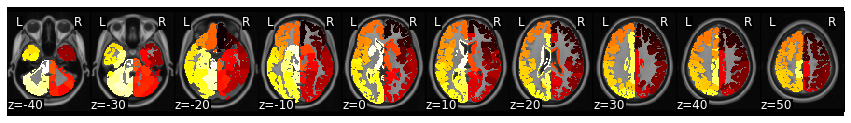

In [31]:
# Mask with 268 parcellations

# Importing mask from Neurovault
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

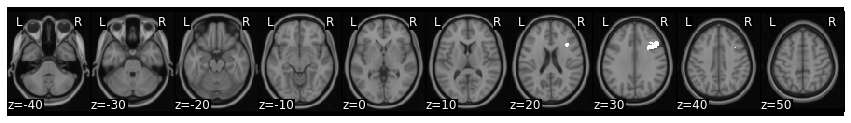

In [75]:
mask_x[21].plot()

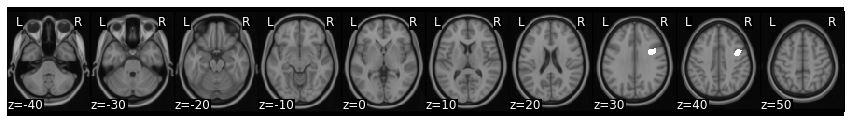

In [76]:
mask_x[30].plot()

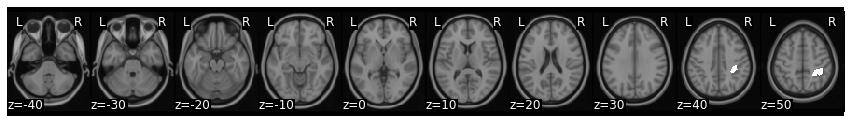

In [77]:
mask_x[37].plot()

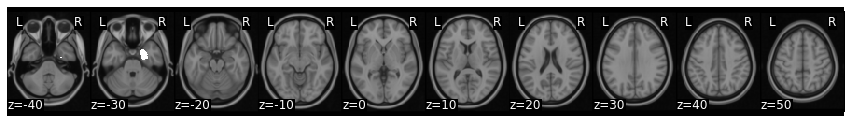

In [78]:
mask_x[96].plot()

In [103]:
x = ['ROI 22\n(Middle Frontal Gyrus)', 'ROI 31\n(Precentral Gyrus)', 'ROI 38\n(Superior Parietal Lobe)', 'ROI 97\n(Parahippocampal Gyrus)']

from pyecharts.charts import EffectScatter

from pyecharts import options as opts
c = (EffectScatter(opts.InitOpts(width='1200px', height='500px')).add_xaxis(x).add_yaxis('Spearman\'s (rho)', tot_nasd_fdr, is_selected=True, symbol_size=10, color='#427fb3',
     label_opts=opts.LabelOpts(is_show=False)).set_global_opts(title_opts=opts.TitleOpts(title='Correlation between per ROI ISC in non-autistic and SRS2', pos_left='left')))
c.render()


'c:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Codes\\render.html'